Given dataset: train.csv and test.csv

Train a model to predict significant learner engagement with a video using provided train.csv. Using this model, return a Pandas Series object of length 2309 with the data being the probability that each corresponding video from readonly test.csv will be engaging (according to a model learned from the 'engagement' label in the training set), and the video index being in the id field.

Example:

id 9240 0.401958 9241 0.105928 9242 0.018572 ... 9243 0.208567 9244 0.818759 9245 0.018528 ... Name: engagement, dtype: float32

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Target a model with an AUC (area under ROC curve) of over 0.85. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0) 

In [2]:
# Loading the dataset

Test = pd.read_csv("test.csv")
Train = pd.read_csv("train.csv")
Train.head()

,id,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate,engagement
0,1,9,7.753995,16310,75.583936,0.553664,0.034049,2.997753,0.0,True
1,2,6,8.305269,15410,86.870523,0.584498,0.018763,2.635789,0.0,False
2,3,3,7.965583,15680,81.915968,0.605685,0.030720,2.538095,0.0,False
3,4,9,8.142877,15610,80.148937,0.593664,0.016873,2.259055,0.0,False
4,5,9,8.161250,14920,76.907549,0.581637,0.023412,2.420000,0.0,False


In [3]:
Test = pd.read_csv("test.csv")
Test.head()

,id,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate
0,9240,6,8.548351,14140,89.827395,0.640810,0.017945,2.262723,0.000000
1,9241,8,7.730110,14600,82.446667,0.606738,0.027708,2.690351,0.000000
2,9242,3,8.200887,16980,88.821542,0.621089,0.009857,3.116071,0.000000
3,9243,5,6.377299,16260,86.874660,0.600000,0.004348,2.837500,0.017994
4,9244,18,7.756530,14030,88.872277,0.616105,0.033240,1.354839,0.000000


In [4]:
# Creating X_train and y_train data from train.csv dataset

X_train = Train.drop(columns= 'engagement')
y_train = Train['engagement'].astype(int) # Currently boolean, so changing them to integer
X_test = Test
print(X_train.shape, y_train.shape, X_test.shape, np.unique(y_train)) # Making sure the shapes are correct.

(9239, 9) (9239,) (2309, 9) [0 1]


Checking if a Logistic regression will give an AUC score of >0.85

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict, GridSearchCV


param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']
}

lr = LogisticRegression(max_iter=300)
grid = GridSearchCV(lr, param_grid, scoring='roc_auc', cv=5)
grid.fit(X_train, y_train)

print("Best AUC:", grid.best_score_)
print("Best Parameters:", grid.best_params_)

Best AUC: 0.8617754863838689
Best Parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


Above result shows we can acheive AUC of >0.85 with Logistic Regression. So, we will use those parameters to fit the model and  calculate the probability.

(9239,)


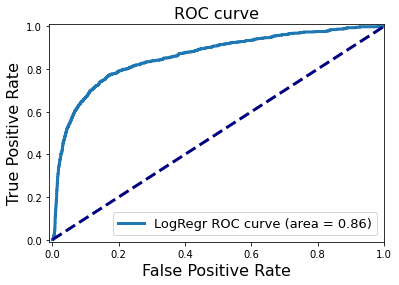

id
9240    0.080188
9241    0.454283
9242    0.464937
9243    0.977281
9244    0.181277
Name: predicted_probability, dtype: float64


In [6]:
# setting up model with best parameters

lr = LogisticRegression(solver = 'liblinear', C = 10, penalty = 'l1', max_iter = 300, random_state = 0, class_weight = 'balanced')



# Predicting class probabilities for each sample in training data with 5-fold cross validation

y_score_lr = cross_val_predict(lr, X_train, y_train, cv=5, method = 'predict_proba')[:, 1]



#making sure the shape is correct

print(y_score_lr.shape)



#Calculating false positive rate and true positive rate from y_train and y_score_lr

fpr_lr, tpr_lr, _ = roc_curve(y_train, y_score_lr)



# Calculating area under the curve from calculated fpr and tpr

roc_auc_lr = auc(fpr_lr, tpr_lr)


#Plotting the ROC curve

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()


# Now we fit the model on training dataset and use the trained model to predict the probabilities that each sample in X-test belongs to class 1 and store the probability values in y_probs.


y_probs = lr.fit(X_train, y_train).predict_proba(X_test)[:, 1]


# Now creating panda series from the y_probs array by associating each predicted probability to ID on the test set.

probability_series = pd.Series(y_probs, index = X_test['id'], name='predicted_probability')


# Checking if the output is correct

print(probability_series.head())
